In [2]:
import numpy as np
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import keras
import keras.layers as layers
import tensorflow as tf

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [5]:
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K
import pickle

In [6]:
df = pd.read_csv("train_set.csv",encoding='latin-1')

In [7]:
df_test = pd.read_csv("test_set.csv")

In [8]:
df.head()

,label,text
0,85389000,pdscpm gb part of panel of chiller
1,85389000,nm p economical extended rot hand parts for c...
2,85389000,lv ma pd trip unit for cvs parts of circuit br...
3,85389000,lv na p trip unit for cvs switch parts of circ...
4,85389000,lv tmd pd trip unit for cvs parts of circuitbr...


In [9]:
df = df.sample(frac=1).reset_index(drop=True)

In [12]:
df.label.value_counts()

85389000    2936
85177090    2581
85369090    2438
39269099    2189
73181500    2033
85366990    1944
85238090    1720
85364900    1714
87089900    1673
33041000    1605
87082900    1451
84713010    1331
Name: label, dtype: int64

In [13]:
label_dict = {85389000:0,
85177090:1,
85369090:2,
39269099:3,
73181500:4,
85366990:5,
85238090:6,
85364900:7,
87089900:8,
33041000:9,
87082900:10,
84713010:11}

In [14]:
df['label'] = df['label'].map(label_dict)

In [15]:
df.head()

,label,text
0,5,pnsi connector list sl pf cable harness
1,1,non lte non sdh equipment card trage bkaacasr...
2,0,programmable controller fxu mt es japan origin
3,11,ahpc pguuqnninnnnnubshp laptophstnnqcr
4,6,issue edis update dvd part no p


In [16]:
dftrain, dtest = train_test_split(df,train_size=0.85)

In [17]:
dtrain, dval = train_test_split(dftrain,train_size=0.85)

In [18]:
(dtrain.shape, dval.shape, dtest.shape)

((17061, 2), (3011, 2), (3543, 2))

In [19]:
tok_raw = Tokenizer()

raw_text = np.hstack([dtrain.text.str.lower(), dval.text.str.lower(), dtest.text.str.lower()])
tok_raw.fit_on_texts(raw_text)

dtrain["text"] = tok_raw.texts_to_sequences(dtrain.text.str.lower())
dval["text"] = tok_raw.texts_to_sequences(dval.text.str.lower())
dtest["text"] = tok_raw.texts_to_sequences(dtest.text.str.lower())

C:\Users\Anshul Shaive\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Anshul Shaive\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Anshul Shaive\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [20]:
dtrain.head()

,label,text
2025,2,"[46, 1, 1475, 448, 134, 87, 1200, 109, 64, 183..."
7841,6,"[14, 15, 13, 8, 9, 3, 4]"
13596,9,"[710, 1201, 1201, 1022, 618]"
13872,0,"[1099, 425, 266, 2, 1, 54, 125]"
17641,3,"[4792, 4792, 7021, 7022, 1100]"


In [21]:
#SEQUENCE VARIABLES ANALYSIS
max_text_seq = np.max( [np.max(dtrain.text.apply(lambda x: len(x))), 
                        np.max(dval.text.apply(lambda x: len(x))),
                        np.max(dtest.text.apply(lambda x: len(x))),
                        ] )
print("max name seq "+str(max_text_seq))

max name seq 21


<AxesSubplot:>

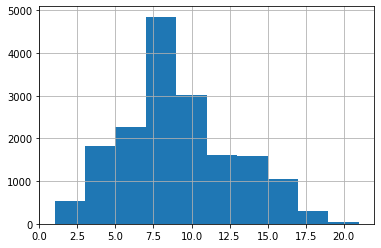

In [22]:
dtrain.text.apply(lambda x: len(x)).hist()

<AxesSubplot:>

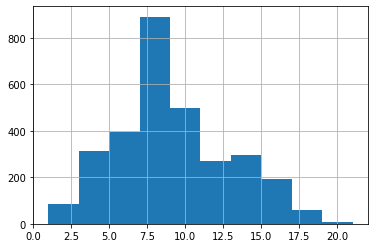

In [23]:
dval.text.apply(lambda x: len(x)).hist()

<AxesSubplot:>

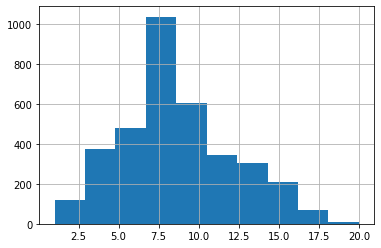

In [24]:
dtest.text.apply(lambda x: len(x)).hist()

In [25]:
MAX_TEXT_SEQ = 21

In [26]:
MAX_TEXT = np.max([np.max(dtrain.text.apply(max)), np.max(dval.text.apply(max)),
                   np.max(dtest.text.apply(max))])+2
MAX_TEXT

13927

In [27]:
class RnnModel:

  def get_keras_data(self,dataset):
    X = {
        'text': pad_sequences(dataset.text, maxlen=MAX_TEXT_SEQ)
    }
    return X
  
  def get_model(self):
    #params
    dr_r = 0.15
    
    #Input
    text = Input(shape=[X_train["text"].shape[1]], name="text")
    
    #Embeddings layer
    emb_text = Embedding(MAX_TEXT, 50)(text)
    
    #rnn layer
    rnn_layer1 = GRU(64) (emb_text)

    main_l = rnn_layer1
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    main_l = BatchNormalization() (main_l)
    main_l = Dropout(dr_r) (Dense(32) (main_l))
    main_l = BatchNormalization() (main_l)
    main_l = Dropout(dr_r) (Dense(16) (main_l))
    main_l = BatchNormalization() (main_l)
 
    #output
    output = Dense(12, activation="softmax") (main_l)
    
    #model
    model = Model([text], output)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [28]:
mod=RnnModel()

In [29]:
X_train = mod.get_keras_data(dtrain)
X_valid = mod.get_keras_data(dval)
X_test  = mod.get_keras_data(dtest)

In [31]:
X_train

{'text': array([[   0,    0,    0, ...,    1,    5,    6],
        [   0,    0,    0, ...,    9,    3,    4],
        [   0,    0,    0, ..., 1201, 1022,  618],
        ...,
        [   0,    0,    0, ...,  101,  141,   68],
        [   0,    0,    0, ...,    1,    5,    6],
        [   0,    0,    0, ...,  636,   91,   57]])}

In [32]:
model=mod.get_model()

In [33]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, 21)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 21, 50)            696350    
_________________________________________________________________
gru (GRU)                    (None, 64)                22272     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 32)               

In [34]:
BATCH_SIZE = 32
epochs = 15

In [35]:
ytrain = pd.get_dummies(dtrain.label).values
yval = pd.get_dummies(dval.label).values
ytest = pd.get_dummies(dtest.label).values

In [36]:
model.fit(X_train, ytrain, epochs=epochs, batch_size=BATCH_SIZE,
          validation_data=(X_valid, yval))

Epoch 1/15
534/534 [==============================] - 7s 14ms/step - loss: 0.9420 - accuracy: 0.7443 - val_loss: 0.5422 - val_accuracy: 0.8974
Epoch 2/15
534/534 [==============================] - 7s 13ms/step - loss: 0.2600 - accuracy: 0.9404 - val_loss: 0.2768 - val_accuracy: 0.9236
Epoch 3/15
534/534 [==============================] - 7s 13ms/step - loss: 0.1272 - accuracy: 0.9715 - val_loss: 0.2772 - val_accuracy: 0.9286
Epoch 4/15
534/534 [==============================] - 7s 13ms/step - loss: 0.0873 - accuracy: 0.9795 - val_loss: 0.3627 - val_accuracy: 0.9120
Epoch 5/15
534/534 [==============================] - 7s 14ms/step - loss: 0.0733 - accuracy: 0.9814 - val_loss: 0.2933 - val_accuracy: 0.9283
Epoch 6/15
534/534 [==============================] - 7s 13ms/step - loss: 0.0625 - accuracy: 0.9835 - val_loss: 0.3286 - val_accuracy: 0.9243
Epoch 7/15
534/534 [==============================] - 7s 13ms/step - loss: 0.0511 - accuracy: 0.9865 - val_loss: 0.2956 - val_accuracy: 0.9276

In [37]:
model.evaluate(X_test, ytest)

111/111 [==============================] - 0s 3ms/step - loss: 0.4253 - accuracy: 0.9179


[0.4253140091896057, 0.9178662300109863]